# Item-Item Top-N Recommendations

In this excercise we will implement a simple top-N recommender, evaluate the algorithms, and then call algorithms from the Surprise package. In top-N recommendations the algorithm is requested to produce a list of N items that the user will be interested in. 
In this particular execercise we will work with an escape room dataset.

First, let's load the dataset, which is already split by time into a training set and a test set:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_set_path = 'resources//train_numerized_with_anon.csv'
test_set_path = 'resources//test_numerized_with_anon.csv'

train_set = pd.read_csv(train_set_path, parse_dates=[3], index_col='index')
test_set = pd.read_csv(test_set_path, parse_dates=[3], index_col='index')

users_in_train = train_set.userID.unique()
test_set = test_set[test_set.userID.isin(users_in_train)]

C:\Users\dmitr\AppData\Local\Temp\ipykernel_15092\708086410.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_set = pd.read_csv(train_set_path, parse_dates=[3], index_col='index')
C:\Users\dmitr\AppData\Local\Temp\ipykernel_15092\708086410.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_set = pd.read_csv(test_set_path, parse_dates=[3], index_col='index')


We can take a look at the structure of the dataset:

In [3]:
train_set.head()

,userID,itemID,rating,timestamp
index,,,,
0,0,0,10,11/11/2015
1,1,0,10,11/11/2015
2,2,0,8,11/11/2015
3,3,0,10,11/11/2015
4,4,0,10,11/11/2015


In [4]:
train_set["rating"] = pd.to_numeric(train_set["rating"])
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40022 entries, 0 to 40021
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userID     40022 non-null  int64 
 1   itemID     40022 non-null  int64 
 2   rating     40022 non-null  int64 
 3   timestamp  40022 non-null  object
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


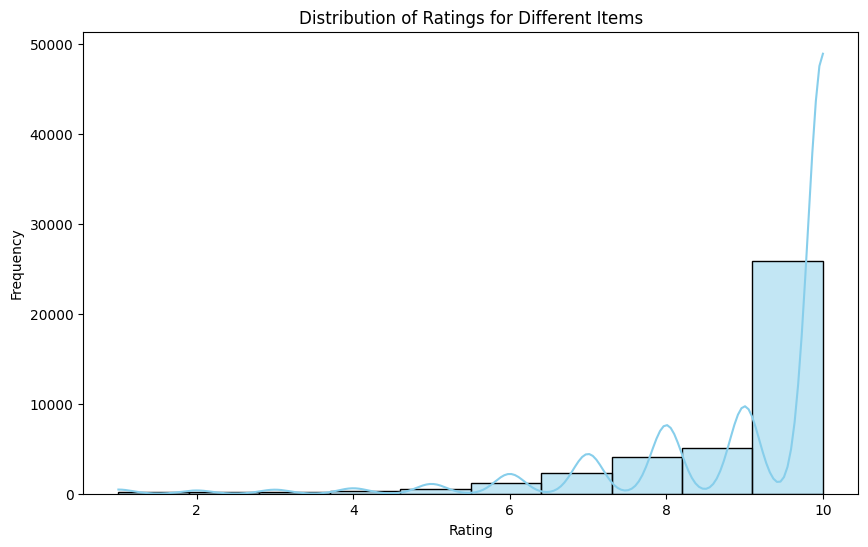

In [5]:
# Histogram distribution with Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=train_set, x='rating', bins=10, kde=True, color='skyblue')

# Set labels and title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings for Different Items')

# Show the plot
plt.show()

## Part 1: Recommend Most Popular Items 

Now we can begin implementing the our first algorithm, that recommends to the user the list of most popular items. Although this is not a personalized approach, in many cases, this is not a bad idea - popular items are popular because everybody choose them, so there is a high likelihood that recommended popular items will be indeed chosen by the user.

In the code below, fill in the missing parts. The algorithm has a training method, where item popularity is computed, and a recommendation method, where the list of popular items.

In [6]:
class MostPopular:

    def __init__(self):
        self.item_ratings_sorted = None
        self.train_set = None

    def learn_model(self, train_set):
        self.train_set = train_set
        #1) Add code to set the item_ratings_sorted to the list of items in the training set, 
        #ordered by decreasing popularity (i.e., the number of users who have chosen an item)
        self.item_ratings_sorted = list(self.train_set.groupby('itemID')['userID'].count().sort_values(ascending=False).index)
        

    def get_top_n_recommendations(self, test_set, top_n):
        result = {}
        already_ranked_items_by_user = self.train_set.groupby('userID')['itemID'].apply(list)
        
        #For each user in the test set compute recommendations
        for userID in test_set.userID.unique():
            result[str(userID)] = []
            
            #2) Add to the result the top N items from the popular list
            result[str(userID)] += self.item_ratings_sorted[:top_n]

            #3) Remove items that the user has already chosen in the training set (already_ranked_items_by_user)
            cross_items = set(result[str(userID)]) & set(already_ranked_items_by_user[userID])

            removed = 0
    
            while cross_items:
                result[str(userID)] = [it for it in result[str(userID)] if it not in cross_items]
                result[str(userID)] += self.item_ratings_sorted[top_n + removed : top_n + removed + len(cross_items)]
                removed += len(cross_items)
                cross_items = set(result[str(userID)]) & set(already_ranked_items_by_user[userID])

        return result

    def clone(self):
        pass


Now we can call the most popular algorithm to deliver a list of reocmmendations. The code below prints the list of top 5 recommended items for user with ID 431.

In [7]:
popular = MostPopular()
popular.learn_model(train_set)
popular_recs = popular.get_top_n_recommendations(test_set,top_n=5)
print(popular_recs['431'])
assert popular_recs['431'] == [53, 26, 68, 85, 16], 'Wrong computation of popular items'

[53, 26, 68, 85, 16]


## Part 2 - Item-Item Recommendations

We now learn a slightly more sophisticated model, that uses item-item similarities. Given such a similarity score, we can recommend to a user items that are most similar to the items that the user has chosen in the past. One such useful similarity metric is the Jaccard coefficient. For two items i1 and i2, the Jaccard similarity is the number of users who have chosen both i1 and i2, divided by the number of users who have chosen either i1 or i2. That is, given the list of users who have chosen i1 and the list of users who have chosen i2, the Jaccard similarity is the intersection of the lists, divided by the union of the lists.

In practice, to expedite the recommendation process, and hence reduce online latency, we will compute the item-item co-occurence matrix in the model learning phase. Then, online, when recommendations are requested, we only need to compute for each item that the user has already chosen in the past, the Jaccard scores for the other items.

As the user has chosen several items in the past, we need to aggregate the Jaccard scores. That is, if the user has previously chosen i1 and i2, item i3 has two scores J(i1,i3) and J(i2,i3), and an aggregation of the scores is needed. There are two popular aggregation functions - sum and max. Empirically, max typically has better perfromance.

Fill in the missing parts in the code below.

In [10]:
from itertools import combinations
item_counts =  train_set.groupby('itemID')['userID'].agg('count')
userData = train_set[train_set.userID == 431]
n_pairs = len(userData)

for item in userData['itemID']:
    item_counts[item] += n_pairs

result = {}
already_ranked_items_by_users = train_set.groupby('userID')['itemID'].apply(list)
result[str(431)] = []
maxvalues = dict()
item_item_counts = dict()

for item1, item2 in combinations(userData['itemID'], 2):

    item_item_counts[(item1, item2)] = item_item_counts.get((item1, item2), 0) + 1
print(item_item_counts)


for item_ranked in already_ranked_items_by_users[431]:
        for pair in item_item_counts:
                if item_ranked in pair:
                    other_item = pair[0] if pair[1] == item_ranked else pair[1]
                    if other_item not in already_ranked_items_by_users[431]:
                          j_score = item_item_counts[pair] / (item_counts[item_ranked] + item_counts[other_item] - item_item_counts[pair])
                          print(j_score)
                          maxvalues[other_item] = max(maxvalues.get(other_item, 0), j_score)

print(maxvalues)


 

{(1, 2): 1, (1, 5): 1, (1, 8): 1, (1, 10): 1, (1, 13): 1, (1, 18): 1, (1, 21): 1, (1, 24): 1, (1, 33): 1, (1, 35): 1, (1, 40): 1, (1, 44): 1, (1, 49): 1, (1, 74): 1, (1, 75): 1, (1, 0): 1, (1, 77): 1, (1, 3): 1, (1, 4): 1, (1, 7): 1, (1, 12): 1, (1, 107): 1, (1, 66): 1, (1, 69): 1, (1, 122): 1, (1, 125): 1, (1, 22): 1, (1, 176): 1, (1, 137): 1, (1, 140): 1, (1, 32): 1, (1, 36): 1, (1, 37): 1, (1, 38): 1, (1, 175): 1, (1, 162): 1, (1, 42): 1, (1, 43): 1, (1, 45): 1, (1, 178): 1, (1, 46): 1, (1, 169): 1, (1, 56): 1, (1, 51): 1, (1, 179): 1, (1, 198): 1, (1, 199): 1, (1, 200): 1, (1, 201): 1, (1, 202): 1, (1, 272): 1, (1, 203): 1, (1, 204): 1, (1, 76): 1, (1, 78): 1, (1, 79): 1, (1, 205): 1, (1, 206): 1, (1, 80): 1, (1, 207): 1, (1, 54): 1, (1, 81): 1, (1, 82): 1, (1, 83): 1, (1, 208): 1, (1, 84): 1, (1, 63): 1, (1, 86): 1, (1, 87): 1, (1, 58): 1, (1, 88): 1, (1, 209): 1, (1, 89): 1, (1, 90): 1, (1, 91): 1, (1, 92): 1, (1, 93): 1, (1, 6): 1, (1, 210): 1, (1, 94): 1, (1, 95): 1, (1, 211): 

In [3]:
from tqdm import tqdm
import numpy as np
import operator
from itertools import combinations

class Jaccard:

    def __init__(self):
        self.item_ratings_sorted = None
        self.train_set = None
        self.item_item_counts = dict()
        self.item_counts = None

    def learn_model(self, train_set):
        print('Started training')
        self.train_set = train_set
        self.item_counts =  self.train_set.groupby('itemID')['userID'].agg('count')
        
        maxpair = 0
        pbar = tqdm(total=len(train_set.userID.unique()))
        
        #Iterating over all item pairs is inefficient. It is better to iterate only over pairs of items that were chosen together.
        #Instead, we will iterate over the users, and for each user, and each two items that the user has chosen, increase the count
        for u in train_set.userID.unique():
            pbar.update(1)
            userData = self.train_set[self.train_set.userID == u]
            
            
            #4) For each pair of items in the user data - increase the counts in self.item_item_counts
            for item1, item2 in combinations(userData['itemID'], 2):
                self.item_item_counts[(item1, item2)] = self.item_item_counts.get((item1, item2), 0) + 1    
                

        pbar.close()
        print('Done training')
            
            
            

    def get_top_n_recommendations(self, test_set, top_n):
        print('Started computing recommendations')
        result = {}
        already_ranked_items_by_users = self.train_set.groupby('userID')['itemID'].apply(list)
        
        pbar = tqdm(total=len(test_set.userID.unique()))
        
        #For each user in the test set compute recommendations
        for userID in test_set.userID.unique():
            pbar.update(1)
            result[str(userID)] = []
            #maxvalues will maintain for each potential item to recommend its highest Jaccard score.
            maxvalues = dict()
            
            #4) Iterate over the items that the user has already chosen.
            #For each such item compute its Jaccard correlation to other items based on the item_item_counts.
            #Aggregate into maxvalues using max.
            #Avoid recommending items that the user has already chosen in the training set.
            for item_ranked in already_ranked_items_by_users[userID]:
                for pair in self.item_item_counts:
                        if item_ranked in pair:
                            other_item = pair[0] if pair[1] == item_ranked else pair[1]
                            if other_item not in already_ranked_items_by_users[userID]:
                                j_score = self.item_item_counts[pair] / (self.item_counts[item_ranked] + self.item_counts[other_item] - self.item_item_counts[pair])
                                maxvalues[other_item] = max(maxvalues.get(other_item, 0), j_score)

            
            #Now we just take the top N items by decreasing Jaccard
            top_list = sorted(maxvalues.items(), key=lambda kv : -kv[1])
            i=0
            j=0
            while i < top_n and j < len(top_list):
                itemID = top_list[j][0]
                j = j + 1
                result[str(userID)].append(itemID)
                i = i + 1
            
        pbar.close()
        print('Done computing recommendations')
        return result

    
    def clone(self):
        pass


The code below trains a Jaccard model and generates recommendations. Training will take a while, as we need to iterate over all users, and for each user go over her items in quadratic time.

In [4]:
jaccard = Jaccard()
jaccard.learn_model(train_set)
jaccard_recs = jaccard.get_top_n_recommendations(test_set,top_n=5)


Started training


  0%|          | 0/20197 [00:00<?, ?it/s]

100%|██████████| 20197/20197 [00:11<00:00, 1821.73it/s]


Done training
Started computing recommendations


100%|██████████| 227/227 [01:36<00:00,  2.35it/s]

Done computing recommendations


In [5]:
jaccard_recs['431']

[296, 297, 298, 299, 300]

As a side note - as computing the ite-item counts takes a while (especially with Python), we are using here the progress bar from the tqdm package (https://pypi.org/project/tqdm/). You need to install tqdm, or remove the progress bar, which would of course is not needed for the algorithm to run.

## Part 3 - Comparing the Algorithms 

We now want to compare the recommendation lists to see which one is better. In top-N recommendations it is popular to computer the Precision@N metric - the portion of recommended items that were chosen by users in the test set. This is typically a reasonable metric for real systems, where one wants to optimize the number of recommended items that are chosen.

We compute Precision@N by comparing the number of recommendations chosen by the users, divided by the number of overall recommendations.

Fill in the missing parts in the code below:

In [16]:
def compute_precision(test_set, recommendations):
    #hits is the number of items that were recommended and chosen
    hits = 0
    #recs is the total number of recommended items
    recs = 0
    
    for u in test_set.userID.unique():
        userData = test_set[test_set.userID == u]['itemID'].unique()
        userRecs = recommendations.get(str(u))
        #5) Compute here the number of hits. Update hits and recs accordingly.
        hits += len(set(userData) & set(userRecs))
        recs += len(userRecs)
    return hits / recs
        
    

In [17]:
p1 = compute_precision(test_set, jaccard_recs)
p2 = compute_precision(test_set, popular_recs)
print("Jaccard=", p1, "  Popularity=", p2)

Jaccard= 0.03524229074889868   Popularity= 0.027312775330396475


The precision values for this dataset may seem pretty low, but this is typical for many top-N problems. It is important not to compute metrics that hide the true values, such as AUC, but to acknowledge the perfromance of the system in the application.

## Part 4 - Calling Algorithms from the Surprise Package

There are many existing recommendation algorithms available. We will now see how we can call algorithms from the Surprise package. 

The code below adds a wrapper around the algorithm to transform the resulting recommendations into our desired format.

#### NOTE: 
To run the code below you first have to install _surprise_ (http://surpriselib.com/). surprise requires scipy >=1.0, so update if needed.

To install: pip install scikit-surprise or, if you're using anaconda:  conda install -c conda-forge scikit-surprise).  

In [ ]:
import sys, string, os
import pandas as pd
import itertools
from tqdm import tqdm
import numpy as np
import operator
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import PredefinedKFold
from surprise.prediction_algorithms import *



class SurpriseRecMethod():

    #method will be the specific Surprise algorithm that we will call
    def __init__(self, method):
        self.method = method

    def fit(self, train_set):
        self.train_set = train_set


    def get_top_n_recommendations(self, test_set, top_n):
        self.test_set = test_set

        #Surprise requires a slightly different input data format, so we use two different CSVs
        test_path_tmp = "resources//test_file.csv"
        train_path_tmp = "resources//train_file.csv"

        self.train_set.to_csv(train_path_tmp, index=False, header=False)
        self.test_set.to_csv(test_path_tmp, index=False, header=False)

        fold_files = [(train_path_tmp, test_path_tmp)]
        reader = Reader(rating_scale=(1, 10), line_format='user item rating', sep=',')
        data = Dataset.load_from_folds(fold_files, reader=reader)

        for trainset, testset in PredefinedKFold().split(data):
            self.method.fit(trainset)

        already_ranked_items_by_users = self.train_set.groupby('userID')['itemID'].apply(list)

        recommendations = {}
        pbar = tqdm(total=len(self.test_set.userID.unique()))
        for userID in self.test_set.userID.unique():
            pbar.update(1)

            if userID not in self.train_set.userID.unique():
                recommendations[str(userID)] = []
                continue

            items_expected_ranking = {}
            for itemID in self.train_set.itemID.unique():
                if itemID in already_ranked_items_by_users[userID]:
                    continue
                #We call here the specific Surprise method that we use for this model
                #The method predicts a score for a given item
                predicted = self.method.predict(str(userID), str(itemID), clip=False)
                items_expected_ranking[itemID] = predicted[3]
                
            #Now we just sort by decreasing scores and take the top N
            sorted_predictions = sorted(items_expected_ranking.items(), key=operator.itemgetter(1))
            sorted_predictions.reverse()
            sorted_predictions = [x[0] for x in sorted_predictions]
            user_recommendations = sorted_predictions[:top_n]
            recommendations[str(userID)] = user_recommendations
        pbar.close()
        return recommendations


The code below calls the package with the SlopeOne algorithm.

In [ ]:
modelSlopeOne = SurpriseRecMethod(SlopeOne())
modelSlopeOne.fit(train_set)
recSlopeOne = modelSlopeOne.get_top_n_recommendations(test_set, 5)
p3 = compute_precision(test_set,recSlopeOne)

The code below calls the package with a nearest neighbor user-item recommendation method.

In [ ]:
modelKNNUser = SurpriseRecMethod(KNNBasic(sim_options={'name': 'cosine', 'user_based': True}))
modelKNNUser.fit(train_set)
recKNNUser = modelKNNUser.get_top_n_recommendations(test_set, 5)
p4 = compute_precision(test_set,recKNNUser)

Let us look at the results of all algorithms together:

In [ ]:
pd.DataFrame.from_dict({'Jaccard':p1,'Popularity':p2,'SlopeOne':p3,'User KNN':p4}, orient='index',columns=['Precision'])

Try the NMF (non-negative matrix factorization) algorithms from the package - https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF.


For this particular dataset, the user nearest neighbor approach worked best. Hence, should we need to choose a method to put online, we should go with this method.